In [1]:
from exp.utils import *
from exp.models import *
from exp.losses import *
from tqdm.notebook import tqdm
from multiprocessing import Pool

import torch
import torch.nn as NN
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

In [2]:
seed = 92
seed_everything(seed)

In [3]:
model_name = "test_training_v4_pneumonia"
model_type = "densenet"
bs = 16
image_size = (224, 224)
device = get_device()
labels = get_labels()

Using the GPU!


In [4]:
label = "Cardiomegaly"

In [5]:
train_df, valid_df, test_df = get_dataframes(include_labels=labels, small=True, small_fraction=0.1)
train_df.shape, valid_df.shape, test_df.shape

/home/favi/work/crx8/exp/utils.py:174: UserWarning: Train-Val-Split currently with patient overlap!
  warnings.warn("Train-Val-Split currently with patient overlap!")


((6921, 24), (1730, 24), (2559, 24))

In [6]:
train_df = get_binary_df(label, train_df)
valid_df = get_binary_df(label, valid_df)
test_df = get_binary_df(label, test_df)

In [7]:
train_label = train_df[[label]].values
#pos_weights = compute_positive_class_weigths(train_label)
neg_weights, pos_weights = compute_class_freqs(train_label)
neg_weights, pos_weights = torch.Tensor(neg_weights), torch.Tensor(pos_weights)

In [8]:
neg_weights, pos_weights

(tensor([0.0176]), tensor([0.9824]))

In [9]:
train_tfs, test_tfs = get_transforms(image_size=image_size)

In [10]:
train_ds = CRX8_Data(train_df, get_image_path(), label, image_size=image_size, transforms=train_tfs)
valid_ds = CRX8_Data(valid_df, get_image_path(), label, image_size=image_size, transforms=test_tfs)
test_ds  = CRX8_Data(test_df , get_image_path(), label, image_size=image_size, transforms=test_tfs)

In [11]:
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size=bs, shuffle=False)

dataloaders = {
    "train": train_dl,
    "val": valid_dl,
    "test": test_dl
}

In [12]:
criterion = get_weighted_loss_with_logits(pos_weights.to(device), neg_weights.to(device))
#criterion = NN.BCEWithLogitsLoss(reduction="mean", pos_weight=pos_weights.to(device))
#criterion = NN.BCEWithLogitsLoss()#reduction="mean", pos_weight=pos_weights.to(device))
#criterion = CustomLoss(reduction="sum", quadratic=False)

In [13]:
model = pretrained_densenet121()
model = model.to(device)

In [14]:
#model

In [15]:
model, transfer_optimizer = transfer_learn_setup(model, 1e-1, model_type)

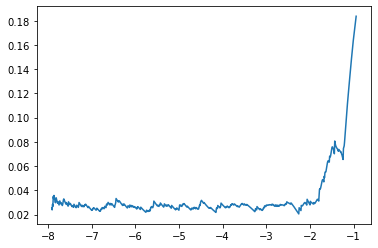

In [16]:
logs,losses = find_lr(model, train_dl, transfer_optimizer, criterion, device=device)
i = 10
plt.plot(logs[i:-i],losses[i:-i]);

In [15]:
lr = 3e-4

In [21]:
model = pretrained_densenet121()
model = model.to(device)

In [ ]:
model, transfer_optimizer = transfer_learn_setup(model, lr, model_type)

In [ ]:
scheduler = get_one_cycle_scheduler(train_dl, lr, transfer_optimizer)

In [ ]:
transfer_epochs = 5

In [ ]:
#torch.cos(torch.Tensor([3.141]))

In [ ]:
model, history = fit(model, criterion, transfer_optimizer, 
                     scheduler, dataloaders, model_name,
                     transfer_epochs,lr, metric="loss")

In [ ]:
plot_history(history)

In [ ]:
plot_history(history, mode="train")

In [ ]:
model = load_model(model_name)
model = model.to(device)

In [16]:
model, fine_optimizer = fine_tune_setup(model, lr)

In [ ]:
logs,losses = find_lr(model, train_dl, fine_optimizer, criterion, device=device)
i = 10
plt.plot(logs[i:-i],losses[i:-i]);

In [ ]:
lr = 3e-5
model = load_model(model_name)
model = model.to(device)

In [ ]:
model, fine_optimizer = fine_tune_setup(model, lr)
scheduler = get_one_cycle_scheduler(train_dl, lr, fine_optimizer)

In [ ]:
fine_epochs = 20

In [ ]:
model, history = fit(model, criterion, fine_optimizer, 
                     scheduler, dataloaders, model_name,
                     fine_epochs, lr, metric="loss")

In [ ]:
model = load_model(model_name)

In [ ]:
preds = validate(model, criterion, test_dl, model_name)

In [ ]:
preds

In [22]:
sam_optimizer = SAM(model.parameters(), torch.optim.SGD, lr=0.001, momentum=0.9)

In [23]:
model, history = train_SAM(model, criterion, sam_optimizer, train_dl, model_name)


Train: Loss: 0.026, Acc: 0.324, AUROC: 0.535


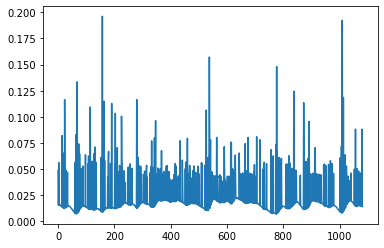

In [28]:
plt.plot(history["loss"])

In [19]:
lr = 3e-4
epochs = 10
model = pretrained_densenet121()
model = model.to(device)
criterion = get_weighted_loss_with_logits(pos_weights.to(device), neg_weights.to(device))
sam_optimizer = SAM(model.parameters(), torch.optim.Adam, lr=lr)

model, history = fit(model, criterion, sam_optimizer, 
                     dataloaders, model_name, epochs, 
                     lr, sam=True, metric="loss")

Epoch 1:



Train: Loss: 0.025, Acc: 0.424, AUROC: 0.554



Val: Loss: 0.023, Acc: 0.523, AUROC: 0.749
Saved model with auroc 0.7489
Epoch 2:



Train: Loss: 0.023, Acc: 0.493, AUROC: 0.633



Val: Loss: 0.021, Acc: 0.799, AUROC: 0.787
Saved model with auroc 0.7871
Epoch 3:



Train: Loss: 0.023, Acc: 0.495, AUROC: 0.672



Val: Loss: 0.022, Acc: 0.534, AUROC: 0.730
Epoch 4:



Train: Loss: 0.024, Acc: 0.461, AUROC: 0.572



Val: Loss: 0.026, Acc: 0.850, AUROC: 0.584
Epoch 5:



Train: Loss: 0.023, Acc: 0.476, AUROC: 0.657



Val: Loss: 0.026, Acc: 0.768, AUROC: 0.707
Lowered lr to 2.9999999999999997e-05
Resetted model to best previous.
Epoch 6:



Train: Loss: 0.022, Acc: 0.577, AUROC: 0.716



Val: Loss: 0.021, Acc: 0.779, AUROC: 0.783
Epoch 7:



Train: Loss: 0.021, Acc: 0.580, AUROC: 0.724



Val: Loss: 0.021, Acc: 0.772, AUROC: 0.781
Epoch 8:



Train: Loss: 0.021, Acc: 0.579, AUROC: 0.740



Val: Loss: 0.021, Acc: 0.584, AUROC: 0.784
Epoch 9:



Train: Loss: 0.021, Acc: 0.585, AUROC: 0.723



Val: Loss: 0.021, Acc: 0.773, AUROC: 0.783
Epoch 10:



Train: Loss: 0.021, Acc: 0.584, AUROC: 0.727



Val: Loss: 0.021, Acc: 0.782, AUROC: 0.784


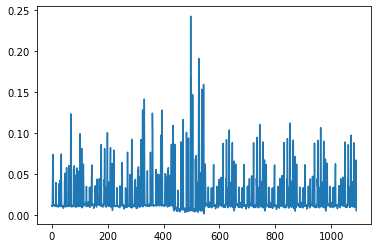

In [21]:
plot_history(history)

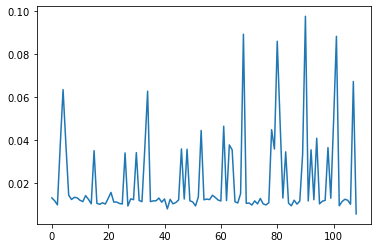

In [25]:
plt.plot(history["e10_val"]["loss"])